# TP 3 Clustering de documents et word2vec

# 1. Choisissez une décennie : 1920


In [14]:
#imports
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [15]:
#import
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/celineransart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
data_path = "../data/txt/"

In [17]:
# Décennie choisie 1920 à 1929
DECADE = '1920'

In [18]:
# Charger tous les  fichiers de la décennie et en créer une liste de textes
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [19]:
# Exemple de fichiers
files[:5]

['KB_JB838_1920-01-13_01-00005.txt',
 'KB_JB838_1920-01-18_01-00014.txt',
 'KB_JB838_1920-02-04_01-00001.txt',
 'KB_JB838_1920-02-04_01-00002.txt',
 'KB_JB838_1920-02-06_01-00004.txt']

In [20]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [21]:
# Exemple de textes
texts[0][:400]

'LE SOIR « Lm Miniafci» Wnrt Itft mmm aoi|aét (|M W TêtoaMHit qu’il* >f<ww>p*‘ jnrntUi chaud** éekw* p**, U* foulard* élégant*, 1* boaiMtori* ooafovUU* d* BOULANGER afrnUmk à la perfection d* la te*»»e. CD. BOULANGER & FUS MAITRES-CHEMISIERS 70, Rie du Lombard, BRUXELLES Tél. : B. 121.32 VA L. EN TA . tiïa. usage constant dans B Ha HOPITAUX ANGLAIS D U BARRV, Bf ION DRES « Hue Duret, 8, Péris, le 1'

In [22]:
# ## Vectoriser les documents à l'aide de TF-IDF
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [23]:
### Instancier le modèle TF-IDF avec ses arguments (à adapter)
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [24]:
### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors = vectorizer.fit_transform(texts)

In [25]:
# Détail de la matrice (nbre de ligne et de colonne)
tfidf_vectors.shape

(1000, 3984)

In [26]:
### Imprimer le vecteur tf-IDF du premier document
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

louer         0.554230
ami           0.124130
jardin        0.120781
env           0.119120
étage         0.108853
                ...   
déclaré       0.000000
découvert     0.000000
découverte    0.000000
décès         0.000000
♦             0.000000
Length: 3984, dtype: float64

# 2. Effectuez un clustering des documents de cette décennie grâce au notebook s2_clustering.ipynb, 

In [28]:
# en adaptant éventuellement le nombre de clusters désirés
N_CLUSTERS = 3

In [29]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [30]:
clusters = km_model.fit_predict(tfidf_vectors)

In [31]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [32]:
pprint(dict(clustering))

{0: ['KB_JB838_1920-01-13_01-00005.txt',
     'KB_JB838_1920-02-08_01-00005.txt',
     'KB_JB838_1920-02-08_01-00010.txt',
     'KB_JB838_1920-02-27_01-00011.txt',
     'KB_JB838_1920-02-29_01-00005.txt',
     'KB_JB838_1920-03-01_01-00004.txt',
     'KB_JB838_1920-03-04_01-00008.txt',
     'KB_JB838_1920-03-19_01-00004.txt',
     'KB_JB838_1920-04-13_01-00008.txt',
     'KB_JB838_1920-04-23_01-00004.txt',
     'KB_JB838_1920-04-25_01-00012.txt',
     'KB_JB838_1920-05-10_01-00006.txt',
     'KB_JB838_1920-05-22_01-00005.txt',
     'KB_JB838_1920-05-28_01-00008.txt',
     'KB_JB838_1920-06-01_01-00008.txt',
     'KB_JB838_1920-06-07_01-00006.txt',
     'KB_JB838_1920-06-24_01-00004.txt',
     'KB_JB838_1920-06-27_01-00012.txt',
     'KB_JB838_1920-07-19_01-00004.txt',
     'KB_JB838_1920-08-18_01-00008.txt',
     'KB_JB838_1920-08-20_01-00008.txt',
     'KB_JB838_1920-09-29_01-00005.txt',
     'KB_JB838_1920-10-03_01-00010.txt',
     'KB_JB838_1920-10-05_01-00005.txt',
     'KB_JB838_1

In [33]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [34]:
reduced_vectors[:10]

array([[ 0.18356754,  0.24448743],
       [-0.10185433,  0.02846894],
       [-0.3108153 , -0.19120199],
       [-0.31158207, -0.17923469],
       [-0.17963196,  0.03291929],
       [ 0.61197193, -0.36957514],
       [ 0.12060385,  0.37042748],
       [-0.11864779,  0.15611588],
       [-0.2982944 , -0.16658354],
       [ 0.02472658,  0.25056315]])

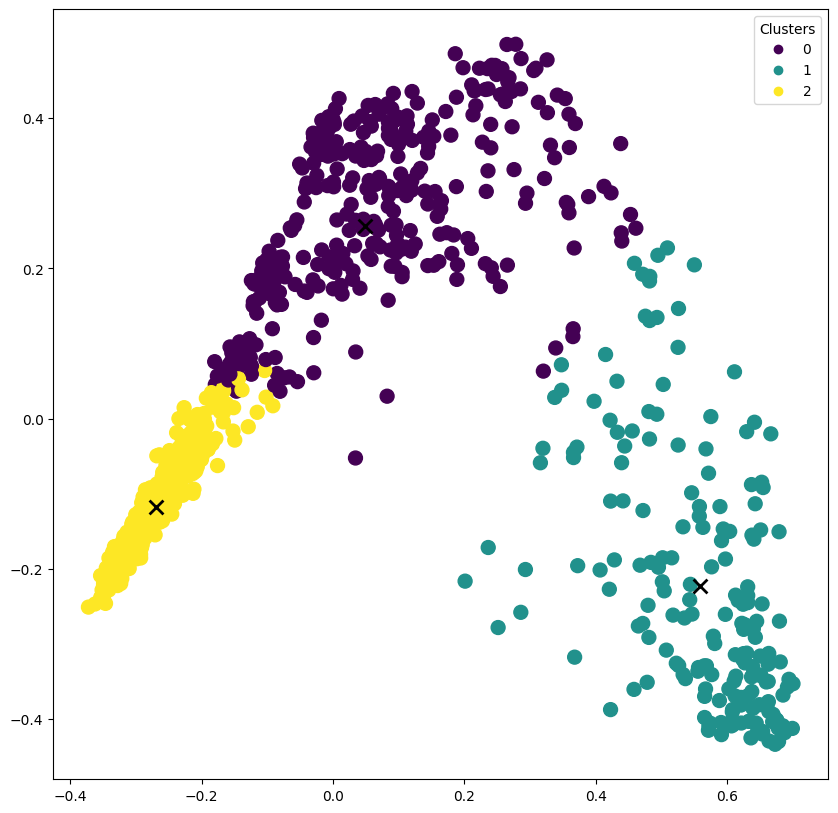

In [35]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Word Embeddings : le modèle Word2Vec

In [36]:
## Imports
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

In [37]:
## Chargement et traitement des phrases du corpus
### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [38]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

In [39]:
### Détection des bigrams
bigram_phrases = Phrases(sentences)

In [40]:
type(bigram_phrases.vocab)

dict

In [41]:
len(bigram_phrases.vocab.keys())

10770576

In [42]:
key_ = list(bigram_phrases.vocab.keys())[144]
print(key_)

;'%


In [43]:
# Le dictionnaire indique le score de cette coocurrence :
bigram_phrases.vocab[key_]

1

In [44]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [45]:
### Extraction des trigrams
trigram_phrases = Phrases(bigram_phraser[sentences])

In [46]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [47]:
### Création d'un corpus d'unigrams, bigrams, trigrams
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [50]:
print(corpus[:20])

[['raege', 'quotidien', 'j00', 'exemplaires_distribues', 'gratuitement', '#', 'k', '.', "'", 'dans', 'ilagg', ';', 'lomeration', 'bruxelloise', 'et', '.', 'en_province', '.'], ['i', 'personnes_habitant', 'aux_etages', 'fenile', 'journal_contre', '60', 'c', '"<<', 'par_mois', '.'], ['fspir', 'est', 'expedie', 'en', 'proyinoe', 'contre', 't', '*>>"', 'par_mois', ',', 'payables_par_trimestre', '.'], ['annonces', ',', 'faits_divers', 'et', 'reclames', 'sjont', 'recu', 'frie', 'd', "'", 'isabelle', ';', 'a', 'l', "'", 'agence', 'rossfjl', '.'], ['44', '.'], ['-', 'v', ',', 'et', 'do', 'l', "'", 'enseignement', ',', 'a', 'braxell', 'annonces_remises_avant', 'midi', 'sont', ';', '-', 'a', ";'%", '>', '1', 'v', '>>^.'], [':', 'vv', '*', "*'*", 'hv', '/', 'f', '#-', 'v', '1', 'v', ';', "'", 'y', '>', 'fif', "'", 'ji', 'l', "'", 'h', '-', 'et', '.'], ['jeudi', '22_decembre', 'i887', 'observatoire', 'roy', "&'", 'cs', 'io', 'decembre', 's', 'heurts', 'uat', '$', 'r', '-:', 'r', 'quotidien_gratuit

## Entrainement d'un modèle Word2Vec sur ce corpus

## 5. Entraînez un modèle word2vec (word embeddings) sur ces phrases 
grâce au notebook s4_model_builder.ipynb, en adaptant éventuellement les
paramètres window (taille de la fenêtre) et min_count (nombre minimum
d’occurrences d’un mot)

In [52]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=10, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: user 8min 30s, sys: 23.2 s, total: 8min 53s
Wall time: 4min 49s


In [53]:
### Sauver le modèle dans un fichier
outfile = f"../data/newspapers.model"
model.save(outfile)

## 6. Explorez le modèle en utilisant les fonctions similarity et most_similar
## (choisissez au moins trois exemples pour chaque fonction)

In [54]:
### Charger le modèle en mémoire
model = Word2Vec.load("../data/newspapers.model")

In [55]:
### Imprimer le vecteur d'un terme
model.wv["ministre"]

array([ -3.7475154 ,  -1.3704747 ,  -4.7957816 ,  -1.709866  ,
        -3.6577258 ,   0.17725356,  -1.1946359 ,   3.467135  ,
         4.763361  ,  -0.2362737 ,   0.04845501,   0.10863259,
        -3.2244048 ,  -3.4459834 , -10.252291  ,   0.48158097,
        -1.5599127 ,   5.2072964 ,   8.501596  ,   4.4430823 ,
        -0.88134944,  -4.7422066 ,   3.723477  ,   2.8246787 ,
        -6.6305017 ,  -1.2984434 ,   4.632214  ,  -0.07087839,
         2.3595567 ,   0.49872196,  -8.761291  ,  -2.3827665 ],
      dtype=float32)

In [63]:
### Calculer la similarité entre deux termes - exemple 1
model.wv.similarity("chien", "chat")

0.76428056

In [62]:
### Calculer la similarité entre deux termes - exemple 2
model.wv.similarity("argent", "francs")

0.43310058

In [66]:
### Calculer la similarité entre deux termes - exemple 3
model.wv.similarity("navire", "bateau")

0.8367934

In [65]:
### Chercher les mots les plus proches d'un terme donné
model.wv.most_similar("navire", topn=10)

[('yacht', 0.9083011150360107),
 ('pilote', 0.8764097094535828),
 ('detachement', 0.8714097142219543),
 ('vaisseau', 0.8601945638656616),
 ('debarquement', 0.8556235432624817),
 ('steamer', 0.8548046350479126),
 ('cuirasse', 0.8533934354782104),
 ('coureur', 0.8503711223602295),
 ('raid', 0.8499630689620972),
 ('bateau', 0.8367934226989746)]

In [72]:
### Faire des recherches complexes à travers l'espace vectoriel - exemple 1
print(model.wv.most_similar(positive=['chien', 'chat'], negative=['oiseau']))

[('mom', 0.7750490307807922), ('haut_prix', 0.737085223197937), ('gel', 0.7299085855484009), ('berger', 0.72549968957901), ('griffon', 0.7225778698921204), ('terrier', 0.7199936509132385), ('bou', 0.7158716917037964), ('bot', 0.7157444357872009), ('sel', 0.7115374803543091), ('bij', 0.7060452699661255)]


In [73]:
### Faire des recherches complexes à travers l'espace vectoriel - exemple 2
print(model.wv.most_similar(positive=['jour', 'semaine'], negative=['heure']))

[('debut', 0.763950765132904), ('cours', 0.6941140294075012), ('chaque_mois', 0.6817044019699097), ('soir_illustre', 0.6685367822647095), ('voyage', 0.6499739289283752), ('monde_entier', 0.646197497844696), ('bilan', 0.6461760997772217), ('travail', 0.6436357498168945), ('jour_comporte', 0.6426467895507812), ('volume', 0.6408693194389343)]


In [75]:
### Faire des recherches complexes à travers l'espace vectoriel - exemple 3
print(model.wv.most_similar(positive=['paris', 'bruxelles'], negative=['belgique']))

[('lundi_29', 0.74737149477005), ('10_heures', 0.7370613217353821), ('2_heures_precises', 0.7298995852470398), ('9_heures', 0.7257565259933472), ('11_heures', 0.7257097959518433), ('10_heures_du_malin', 0.7195538878440857), ('lundi_26', 0.7141789197921753), ('jeudi_28', 0.7140447497367859), ('une_messe_solennelle', 0.7069154977798462), ('mai_1902', 0.7068182826042175)]
